In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, Flatten, Dense, BatchNormalization, Dropout

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    from google.colab import files
    import zipfile
    import os
    uploaded = files.upload()
    for file_name in uploaded.keys():
      if file_name.endswith('.zip'):
          with zipfile.ZipFile(file_name, 'r') as zip_ref:
              zip_ref.extractall("data")

Saving data.zip to data.zip


In [ ]:
# Read and clean data
if using_colab:
  crash_data = pd.concat((pd.read_csv(f'data/data/crash_data_{i}.csv') for i in range(2010, 2023)))
else:
  crash_data = pd.concat((pd.read_csv(f'data/crash_data_{i}.csv') for i in range(2010, 2023)))

# Drop rows with missing target values (latitude and longitude)
crash_data.dropna(subset=['latitude', 'longitud'], inplace=True)

# Filter out rows where latitude and longitude are not in the appropriate range
crash_data = crash_data[(crash_data['latitude'] >= -90) & (crash_data['latitude'] <= 90) & (crash_data['longitud'] >= -180) & (crash_data['longitud'] <= 180)]

min_lat, max_lat = np.min(crash_data['latitude']), np.max(crash_data['latitude'])
min_lon, max_lon = np.min(crash_data['longitud']), np.max(crash_data['longitud'])

# Fill other missing values
crash_data.fillna(method='ffill', inplace=True)

# Create time_in_minutes from hour and minute columns
crash_data['time_in_minutes'] = crash_data['hour'] * 60 + crash_data['minute']

# Onehot Encoding
crash_data = pd.get_dummies(crash_data, columns=['statename', 'routename'], drop_first=True)

# Normalization
scaler = MinMaxScaler()
numerical_cols = ['latitude', 'longitud', 'fatals', 'drunk_dr']
crash_data[numerical_cols] = scaler.fit_transform(crash_data[numerical_cols])

#print(crash_data.head())


<ipython-input-5-dbec3a06e3bd>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  crash_data.fillna(method='ffill', inplace=True)


In [8]:
def preprocess_fars_data_optimized(data, grid_size=(64, 64), time_steps=12, freq='6H'):
    """
    Optimized preprocessing for FARS traffic accident data to reduce memory usage.

    Args:
        data (pd.DataFrame): Traffic accident dataset.
        grid_size (tuple): Dimensions of the spatial grid (rows, cols).
        time_steps (int): Number of time steps for sequence input.
        freq (str): Frequency for temporal aggregation (e.g., '6H', 'D').

    Returns:
        X (np.array): Input data of shape (samples, time_steps, grid_size[0], grid_size[1], 1).
        y (np.array): Output labels of shape (samples, grid_size[0], grid_size[1]).
    """


    # Normalize latitude and longitude to map to grid
    min_lat, max_lat = data['latitude'].min(), data['latitude'].max()
    min_lon, max_lon = data['longitud'].min(), data['longitud'].max()

    data['grid_x'] = ((data['longitud'] - min_lon) / (max_lon - min_lon) * (grid_size[1] - 1)).astype(int)
    data['grid_y'] = ((data['latitude'] - min_lat) / (max_lat - min_lat) * (grid_size[0] - 1)).astype(int)

    # Add a datetime column for grouping
    data['datetime'] = pd.to_datetime({
        'year': data['year'],
        'month': data['month'],
        'day': data['day'],
        'hour': data['hour'].fillna(0).astype(int)
    })

    # Group by time intervals
    time_groups = data.groupby(pd.Grouper(key='datetime', freq=freq))
    grids = []
    for _, group in time_groups:
        grid = np.zeros(grid_size, dtype=np.float32)
        for _, row in group.iterrows():
            grid[row['grid_y'], row['grid_x']] += 1
        grids.append(grid)

    # Create sequences for ConvLSTM
    X, y = [], []
    for i in range(len(grids) - time_steps):
        X.append(grids[i:i + time_steps])
        y.append(grids[i + time_steps])

    X = np.array(X).reshape(-1, time_steps, grid_size[0], grid_size[1], 1)
    y = np.array(y).reshape(-1, grid_size[0], grid_size[1])

    return X, y

# Reprocess the dataset with optimized settings
optimized_grid_size = (64, 64)
optimized_time_steps = 12
optimized_frequency = '6H'

X_opt, y_opt = preprocess_fars_data_optimized(crash_data, optimized_grid_size, optimized_time_steps, optimized_frequency)

# Check the shapes of processed data
X_opt.shape, y_opt.shape


<ipython-input-8-85371d98ee63>:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_groups = data.groupby(pd.Grouper(key='datetime', freq=freq))


((18993, 12, 64, 64, 1), (18993, 64, 64))

<ipython-input-8-85371d98ee63>:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_groups = data.groupby(pd.Grouper(key='datetime', freq=freq))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
760/760 ━━━━━━━━━━━━━━━━━━━━ 91s 106ms/step - loss: 0.7716 - mae: 0.3762 - val_loss: 0.0136 - val_mae: 0.0513
Epoch 2/20
760/760 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - loss: 0.2247 - mae: 0.2628 - val_loss: 0.0216 - val_mae: 0.1229
Epoch 3/20
760/760 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - loss: 0.0561 - mae: 0.1440 - val_loss: 0.0072 - val_mae: 0.0382
Epoch 4/20
760/760 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - loss: 0.0271 - mae: 0.0985 - val_loss: 0.0064 - val_mae: 0.0255
Epoch 5/20
760/760 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - loss: 0.0155 - mae: 0.0688 - val_loss: 0.0063 - val_mae: 0.0260
Epoch 6/20
760/760 ━━━━━━━━━━━━━━━━━━━━ 74s 97ms/step - loss: 0.0105 - mae: 0.0444 - val_loss: 0.0060 - val_mae: 0.0163
Epoch 7/20
760/760 ━━━━━━━━━━━━━━━━━━━━ 73s 97ms/step - loss: 0.0087 - mae: 0.0334 - val_loss: 0.0060 - val_mae: 0.0139
Epoch 8/20
760/760 ━━━━━━━━━━━━━━━━━━━━ 73s 97ms/step - loss: 0.0077 - mae: 0.0271 - val_loss: 0.0060 - val_mae: 0.0156
Epoch 9/20
760/760 ━━━━━━━━━━━━━━━━━━━━

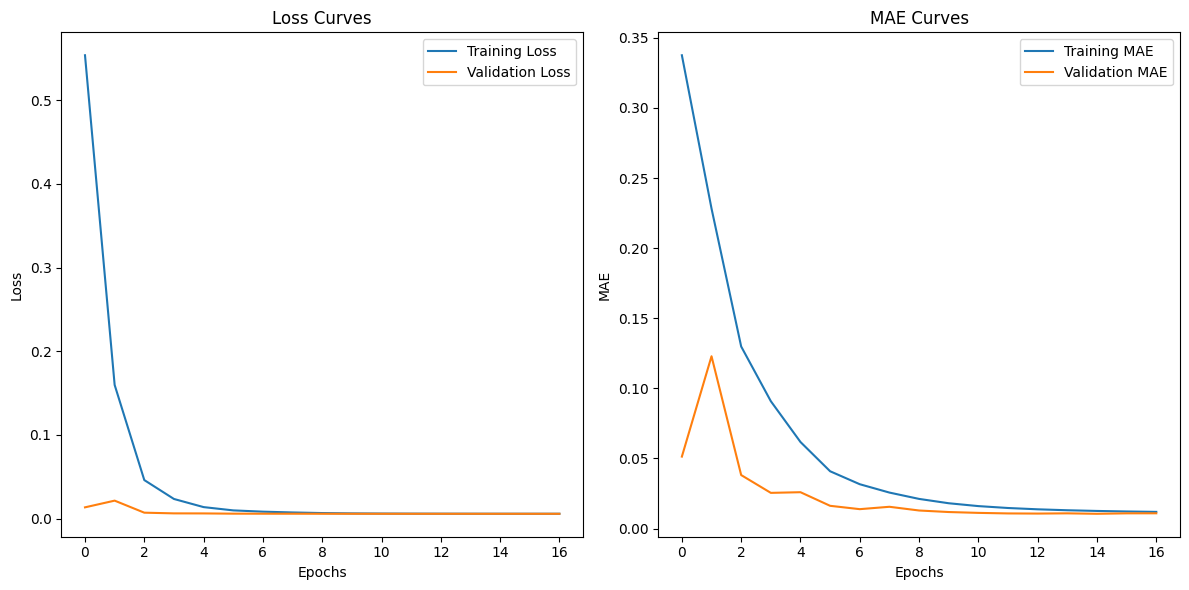

In [12]:
def build_convlstm_model(input_shape):
    """
    Builds the ConvLSTM model for predicting accident locations.

    Args:
        input_shape (tuple): Shape of the input data (time_steps, grid_x, grid_y, channels).

    Returns:
        model (tf.keras.Model): Compiled ConvLSTM model.
    """
    model = Sequential([
        ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False),
        BatchNormalization(),
        Dropout(0.2),
        Conv2D(filters=1, kernel_size=(1, 1), activation='linear', padding='same')  # Linear activation for regression
    ])

    optimizer = Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Preprocess data
grid_size = (64, 64)
time_steps = 12
X, y = preprocess_fars_data_optimized(crash_data, grid_size, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
input_shape = (time_steps, grid_size[0], grid_size[1], 1)
model = build_convlstm_model(input_shape)
early_stopping = EarlyStopping(monitor='val_mae', patience=4, min_delta=0.001, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=16, callbacks=[early_stopping])

# Evaluate model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Get loss and mae
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history.get('mae', history.history.get('mae'))
val_acc = history.history.get('val_mae', history.history.get('val_mae'))

# Plot Loss Curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE Curves
plt.subplot(1, 2, 2)
plt.plot(range(len(train_acc)), train_acc, label='Training MAE')
plt.plot(range(len(val_acc)), val_acc, label='Validation MAE')
plt.title('MAE Curves')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
model.save("convlstm_model.keras")


In [16]:
files.download('/content/convlstm_model.keras')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
#Convert MAE to mi

print(f"Latitude bounds: {min_lat} to {max_lat}")
print(f"Longitude bounds: {min_lon} to {max_lon}")

# Approximate the average latitude for the grid
avg_lat = np.mean([min_lat, max_lat])

# Convert to kilometers
lat_distance_km = (max_lat - min_lat) * 111  # Latitude distance
lon_distance_km = (max_lon - min_lon) * 111 * np.cos(np.radians(avg_lat))  # Longitude distance

# Total area in km²
total_area_km2 = lat_distance_km * lon_distance_km

print(f"Grid Area: {total_area_km2:.2f} km²")

# Number of grid cells
grid_size = (64, 64)
num_cells = grid_size[0] * grid_size[1]

# Area per grid cell
area_per_cell_km2 = total_area_km2 / num_cells

print(f"Area per grid cell: {area_per_cell_km2:.4f} km²")


Latitude bounds: 17.95940833 to 71.30268611
Longitude bounds: -174.20418056 to -65.4897
Grid Area: 50848334.78 km²
Area per grid cell: 12414.1442 km²


In [18]:
#Convert to miles

# Inputs
mae_grid_cells = 0.0106

# Compute side length in km and convert to miles
side_length_km = np.sqrt(area_per_cell_km2)
side_length_miles = side_length_km * 0.621371

# Compute MAE in miles
mae_miles = mae_grid_cells * side_length_miles

print(f"Side Length per Grid Cell: {side_length_miles:.2f} miles")
print(f"MAE in Miles: {mae_miles:.4f} miles")


Side Length per Grid Cell: 69.23 miles
MAE in Miles: 0.7339 miles


594/594 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step


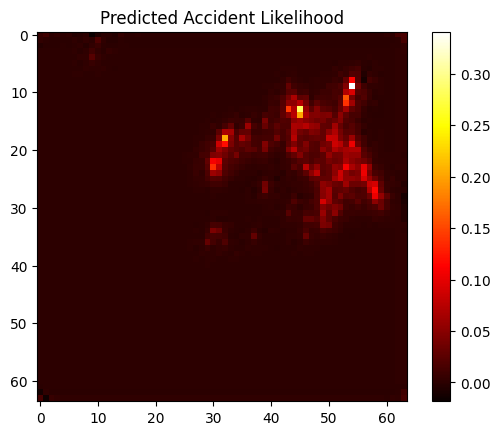

Top N accident locations (x, y): [(14, 0), (0, 0), (1, 0), (62, 0), (63, 0)]


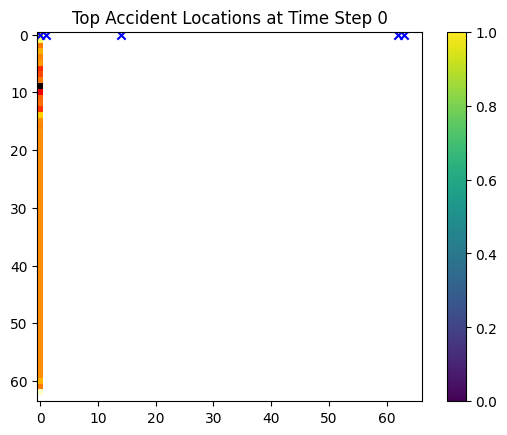

In [21]:
loaded_model = load_model("convlstm_model.keras")

prediction = loaded_model.predict(X_opt)

plt.imshow(prediction[0, :, :], cmap='hot', interpolation='nearest')
plt.title('Predicted Accident Likelihood')
plt.colorbar()
plt.show()

N = 5
time_step = 0

prediction_at_time_step = prediction[0, time_step, :, :]
prediction_flat = prediction_at_time_step.flatten()
top_indices = np.argsort(prediction_flat)[-N:]
top_locations = [(idx // 64, idx % 64) for idx in top_indices]

unnormalized_locations = []
for loc in top_locations:
    grid_y, grid_x = loc

    # Unnormalize latitude and longitude
    longitude_unnormalized = grid_x * (max_lon - min_lon) / (grid_size[1] - 1) + min_lon
    latitude_unnormalized = grid_y * (max_lat - min_lat) / (grid_size[0] - 1) + min_lat

    unnormalized_locations.append((latitude_unnormalized, longitude_unnormalized))

flipped_locations = [(loc[1], loc[0]) for loc in top_locations]
print("Top N accident locations (x, y):", flipped_locations)

plt.imshow(prediction_at_time_step, cmap='hot', interpolation='nearest')
for loc in top_locations:
    plt.scatter(loc[1], loc[0], color='blue', marker='x', label='Top Location')

plt.title(f'Top Accident Locations at Time Step {time_step}')
plt.colorbar()
plt.show()